<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip3.5 install xgboost

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "15g") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *

Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [2]:
DATA_PATH = '/workspace/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [3]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [4]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [5]:
df = df.sample(False, 0.5)

In [6]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]

In [7]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [8]:
!ls /workspace/data/criteo
#!rm -r /workspace/data/criteo/criteo_pipeline_meantarget/

criteo_pipeline_1hot_top2  pipe_xgb_1hot_top2  train.csv
criteo_pipeline_1hot_top5  pipe_xgb_1hot_top5  xgblr_lr.model
criteo_pipeline_mt_top2    pipe_xgb_mt_top2    xgblr_pipeline
logreg_mt_top2.model	   pipe_xgb_mt_top5    xgblr_xgb.model
logreg_top2.model	   results	       xgb_mt_top2.model
logreg_top5.model	   test.csv	       xgb_top2.model


In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

indexers = [StringIndexer(inputCol=col, outputCol=col + "Indexer", handleInvalid='keep') for col in cat_columns]
onehot = [OneHotEncoderEstimator(inputCols=[col + "Indexer" for col in cat_columns],
                                outputCols=[col + "1Hot" for col in cat_columns])]
vectorass = [VectorAssembler(inputCols=num_columns + [col + "1Hot" for col in cat_columns], outputCol="features")]

pipeline_onehot = Pipeline(stages=indexers + onehot + vectorass)
pipeline_onehot = pipeline_onehot.fit(df)

In [10]:
pipeline_onehot.stages

[StringIndexer_d2d8abb56a1f,
 StringIndexer_91c8252d3a43,
 OneHotEncoderEstimator_0dd78ccc2559,
 VectorAssembler_aa6ba582a3d0]

In [13]:
len(pipeline_onehot.stages[0].labels), len(pipeline_onehot.stages[1].labels)

(1445, 556)

Итоговая размерность пространства фичей

In [14]:
dim_onehot = len(num_columns) + len(pipeline_onehot.stages[0].labels) + len(pipeline_onehot.stages[1].labels)
dim_onehot

2014

In [11]:
df_1hot = pipeline_onehot \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()


In [12]:
train_df_1hot, val_df_1hot, test_df_1hot = split_by_col(df_1hot, 'id', [0.8, 0.1, 0.1])

### Train

In [13]:
xgb_estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.3,
    gamma=3.,
    max_depth=10,
    min_child_weight=25.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [14]:
xgb_model = xgb_estimator.fit(train_df_1hot)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [15]:
!rm -r /workspace/data/criteo/xgb_top2.model
xgb_model._call_java("booster").saveModel(os.path.join(DATA_PATH, 'xgb_top2.model'))

### Evaluation

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [16]:
import pandas as pd

def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    metrics_names = groups[control_name].keys()
    metrics_to_id = {m:i for i, m in enumerate(metrics_names)}
    models_names = groups.keys()
    models_to_id = {m:i for i, m in enumerate(models_names)}
    data = {m:[-1] * len(metrics_names) for m in models_names}
    
    metrics_baseline = [groups[control_name][met] for met in metrics_names]
    
    for model_name in groups:
        for metric_name in groups[model_name]:
            model_id = models_to_id[model_name]
            metric_id = metrics_to_id[metric_name]
            delta = (groups[model_name][metric_name] - metrics_baseline[metric_id]) / metrics_baseline[metric_id] * 100.
            data[model_name][metric_id] = delta
    return pd.DataFrame(data, index = metrics_names)
    

In [17]:
def collect_metrics(models, metrics):
    result = {}
    for model_name in models:
        model, df, probab_col = models[model_name]
        d = {}
        for metric_name in metrics:
            metric = metrics[metric_name]
            d[metric_name] = metric(model, df, probab_col)
        result[model_name] = d
    return result

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [18]:
from pyspark.ml.classification import LogisticRegression

logreg = LogisticRegression(featuresCol = 'features', labelCol = 'label',
                            maxIter=20, regParam=0., elasticNetParam=0.)
logreg_1hot = logreg.fit(train_df_1hot)

In [19]:
rocauc(xgb_model, val_df_1hot, 'probabilities')

0.7314177925115664

In [20]:
rocauc(logreg_1hot, val_df_1hot, 'probability')

0.699262779152051

In [21]:
all_metrics = collect_metrics({'logreg_1hot': (logreg_1hot, test_df_1hot, 'probability'),
                               'xgb_1hot': (xgb_model, test_df_1hot, 'probabilities')}, {'ROC AUC': rocauc})
all_metrics

{'logreg_1hot': {'ROC AUC': 0.6994823331970981},
 'xgb_1hot': {'ROC AUC': 0.7301071542090272}}

Построить таблицу ATE используя метод `get_ate`

In [22]:
ate = get_ate(all_metrics, 'logreg_1hot')
ate

,logreg_1hot,xgb_1hot
ROC AUC,0.0,4.378212


## New Model
### Prepare Data

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [23]:
df_mt = df

In [24]:
# Fitted Model
from pyspark.sql.types import *
from pyspark.sql.window import Window
import sys
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param import Params
        
class MeanTargetEncoderHistoricModel(pyspark.ml.Model, DefaultParamsReadable, DefaultParamsWritable):
    inputCol = Param(Params._dummy(), 'inputCol', '')
    featuresCol = Param(Params._dummy(), 'featuresCol', '')
    fitted = Param(Params._dummy(), 'fitted', '')
    apriori = Param(Params._dummy(), 'apriori', '')
    alpha = Param(Params._dummy(), 'alpha', '')
    
    def __init__(self, inputCol=None, featuresCol=None, fitted=None, apriori=0., alpha=0.):
        super(MeanTargetEncoderHistoricModel, self).__init__()
        self._resetUid(self.uid)
        
        if inputCol is not None:
            self.set(self.inputCol, inputCol)
        if featuresCol is not None:
            self.set(self.featuresCol, featuresCol)
        if apriori is not None:
            self.set(self.apriori, apriori)
        if fitted is not None:
            self.set(self.fitted, fitted)
        if alpha is not None:
            self.set(self.alpha, alpha)  

    
    def transform(self, df):
        alpha = self.getOrDefault(self.alpha)
        apriori = self.getOrDefault(self.apriori)
        inputCol = self.getOrDefault(self.inputCol)
        featuresCol = self.getOrDefault(self.featuresCol)
        fitted = sqlContext.createDataFrame(self.getOrDefault(self.fitted), ['cat', 'sum', 'count'])
        
        
        res = df\
            .join(fitted, fitted['cat'] == df[inputCol],how='left')\
            .fillna(0, subset=['sum', 'count'])\
            .withColumn(featuresCol,
                        (F.col('sum') + F.lit(apriori) * F.lit(alpha)) / (F.col('count') + F.lit(alpha)))\
            .drop('sum', 'count', 'cat')
        return res


# Estimator
class MeanTargetEncoderHistoric(pyspark.ml.Estimator):
    
    def __init__(self, orderCol, inputCol, targetCol, featuresCol):
        super(MeanTargetEncoderHistoric, self).__init__()
        self.inputCol = inputCol
        self.orderCol = orderCol
        self.targetCol = targetCol
        self.featuresCol = featuresCol
        
    
    def fit(self, df) -> MeanTargetEncoderHistoricModel:
        from pyspark.sql.window import Window
        import sys
        window_before = Window.orderBy(self.orderCol).partitionBy(self.inputCol).rowsBetween(-sys.maxsize, -1)
        window_all = Window.partitionBy(self.inputCol)
        fitted = df.withColumn('val', F.mean(self.targetCol).over(window_before))\
            .fillna(0, subset='val')\
            .withColumn('sum', F.sum('val').over(window_all))\
            .withColumn('count', F.count('val').over(window_all))\
            .withColumnRenamed(self.inputCol, 'cat')\
            .select('cat', 'sum', 'count')\
            .distinct()
        apriori = df.agg(F.avg(self.targetCol).alias('apr')).collect()[0]['apr']
        fitted = fitted.collect()
        return MeanTargetEncoderHistoricModel(self.inputCol, self.featuresCol, fitted, apriori, 1.)

#### Pipeline

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoderHistoric('id', cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [26]:
pipeline_meantarget = pipeline.fit(df_mt)
#!rm -r /workspace/data/criteo/criteo_pipeline_mt_top2/
pipeline_meantarget.save(os.path.join(DATA_PATH, 'criteo_pipeline_mt_top2'))

In [29]:
from pyspark.ml import PipelineModel

pipeline_meantarget = PipelineModel.load(os.path.join(DATA_PATH, 'criteo_pipeline_mt_top2'))

In [27]:
df_mt = pipeline_meantarget \
    .transform(df_mt) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

### Train

Train XGBoost on the new set of features

In [28]:
train_df_mt, val_df_mt, test_df_mt = split_by_col(df_mt, 'id', [0.8, 0.1, 0.1])
xgb_mt_model = xgb_estimator.fit(train_df_mt)

#!rm -r /workspace/data/criteo/xgb_mt_top2.model
#xgb_mt_model._call_java("booster").saveModel(os.path.join(DATA_PATH, 'xgb_mt_top2.model'))

In [29]:
logreg_mt = logreg.fit(train_df_mt)

#!rm -r /workspace/data/criteo/logreg_mt_top2.model
#logreg_mt.save(os.path.join(DATA_PATH, 'logreg_mt_top2.model'))

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [30]:
tmp_dict = {'ROC AUC': rocauc(xgb_mt_model, test_df_mt, 'probabilities')}
all_metrics['xgb_mt_model'] = tmp_dict
all_metrics

{'logreg_1hot': {'ROC AUC': 0.6994823331970981},
 'xgb_1hot': {'ROC AUC': 0.7301071542090272},
 'xgb_mt_model': {'ROC AUC': 0.7340227199458784}}

In [34]:
ate = get_ate(all_metrics, 'logreg_1hot')
ate

,logreg_1hot,xgb_1hot,xgb_mt_model
ROC AUC,0.0,4.378212,4.937993


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [39]:
!pip3.5 install shap

In [21]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.model'))

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


[19:09:20] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [51]:
print(bst.get_dump()[0])

0:[f0<5775] yes=1,no=2,missing=2
	1:[f5<7.99999905] yes=3,no=4,missing=3
		3:[f10<1.99999905] yes=7,no=8,missing=7
			7:[f4<11.999999] yes=15,no=16,missing=15
				15:[f12<1.99999905] yes=31,no=32,missing=31
					31:[f1558<2.00000095] yes=63,no=64,missing=64
						63:[f0<8.99999905] yes=127,no=128,missing=128
							127:leaf=0.160194188
							128:leaf=0.28687501
						64:[f1458<2.00000095] yes=129,no=130,missing=130
							129:[f11<37] yes=253,no=254,missing=254
								253:leaf=0.160034314
								254:leaf=0.073301211
							130:[f1524<2.00000095] yes=255,no=256,missing=256
								255:leaf=0.230952382
								256:leaf=-0.0164990742
					32:[f3<7.99999905] yes=65,no=66,missing=66
						65:[f12<3.99999905] yes=131,no=132,missing=132
							131:[f3<3.99999905] yes=257,no=258,missing=258
								257:leaf=-0.0743231103
								258:leaf=-0.00889621116
							132:[f1458<2.00000095] yes=259,no=260,missing=260
								259:leaf=-0.047532469
								260:leaf=-0.118471347
						66:[f11<18.999998

In [17]:
sample_df = train_df.sample(False, 0.05)
sample_df.count()

73293

In [23]:
sample_df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- id: long (nullable = true)



In [39]:
from scipy.sparse import csr_matrix


def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    for i, vec in enumerate(sparse_vecs):
        for idx, val in zip(vec.indices, vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [40]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

CPU times: user 3.36 s, sys: 76.4 ms, total: 3.44 s
Wall time: 4.67 s


In [69]:
tmp_pred = bst.predict(dtest, pred_leaf=True)
tmp_pred

array([[381, 405, 398, ..., 235, 266, 168],
       [437, 426, 330, ..., 211, 232, 142],
       [479, 476, 419, ..., 278, 268, 168],
       ...,
       [355, 361, 240, ..., 188, 202, 142],
       [328, 336, 304, ..., 212, 232, 152],
       [437, 425, 331, ..., 242, 202, 142]], dtype=int32)

In [41]:
X_arr = X.toarray()

In [42]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 2min 41s, sys: 578 ms, total: 2min 42s
Wall time: 11.4 s


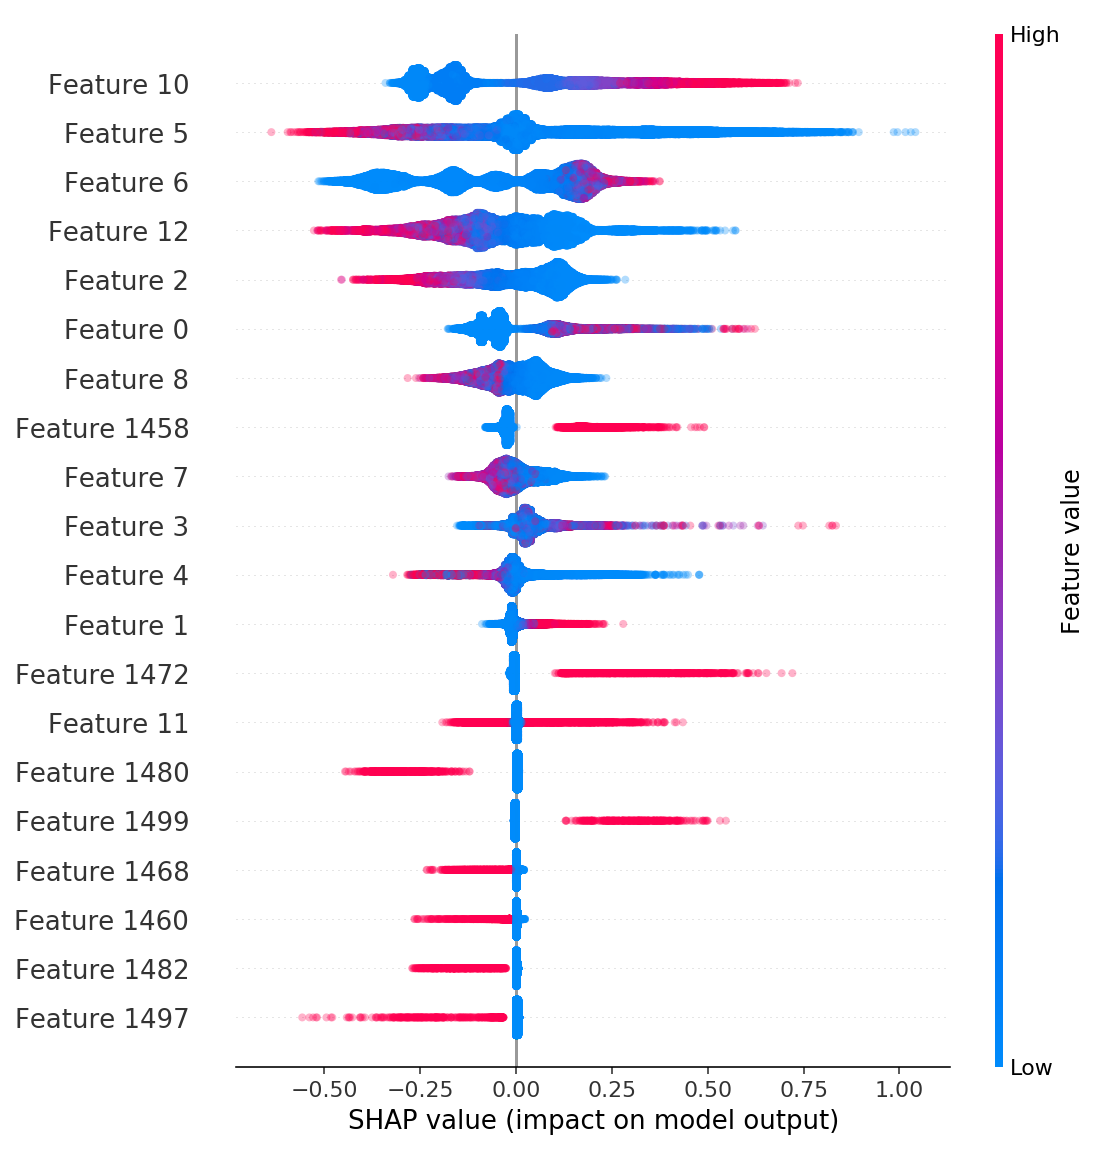

In [43]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [44]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [45]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

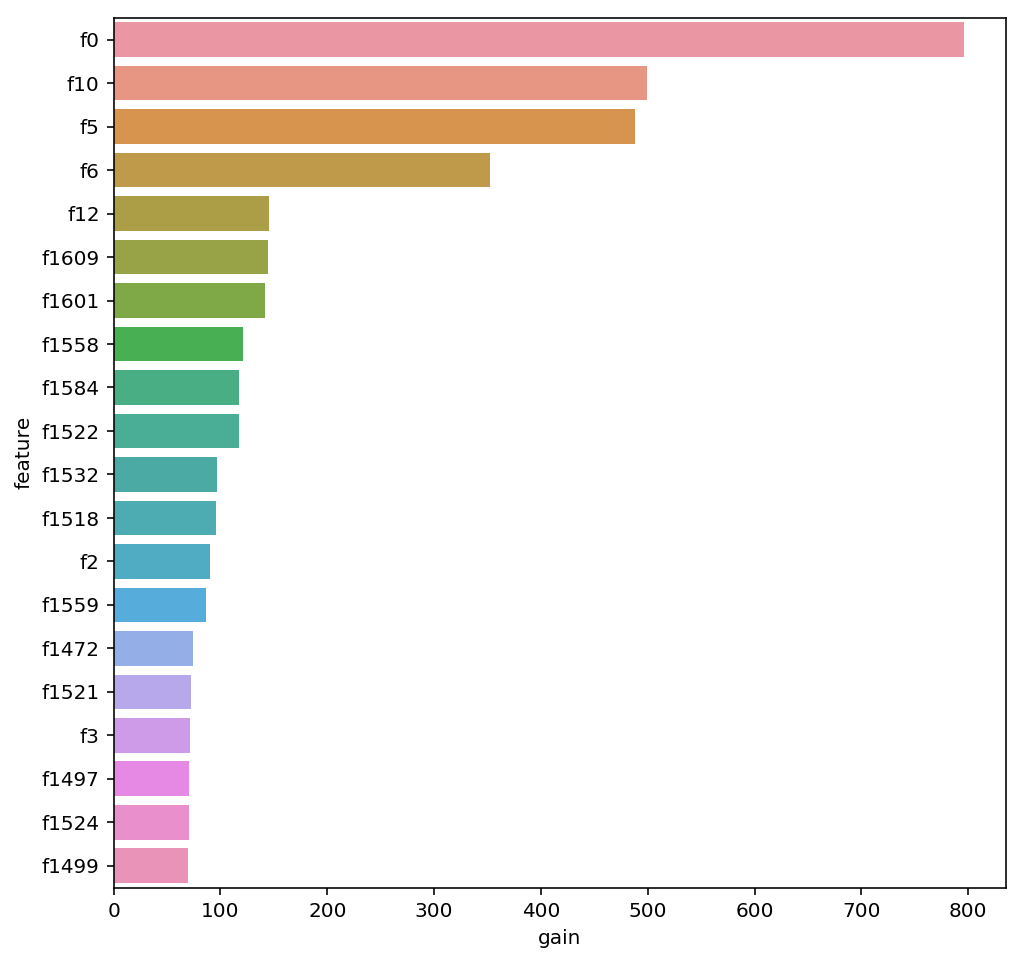

In [46]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [54]:
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
import xgboost as xgb
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from scipy.sparse import csr_matrix
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.sql import Window

XGBLR_XGB_PATH = os.path.join(DATA_PATH, 'xgblr_xgb.model')
XGBLR_LR_PATH = os.path.join(DATA_PATH, 'xgblr_lr.model')
XGBLR_PIPELINE_PATH = os.path.join(DATA_PATH, 'xgblr_pipeline')

class XGBLRModel(pyspark.ml.Model):
    
    def __init__(self, dim, xgb_save_path, lr_save_path, pipe_save_path):
        super(XGBLRModel, self).__init__()
        self.dim = dim
        self.xgb_save_path=xgb_save_path
        self.lr_save_path=lr_save_path
        self.pipe_save_path=pipe_save_path
        
    def df_to_csr(self, df, dim):
        data = []
        row_ind = []
        col_ind = []

        sparse_vecs = df.rdd.map(lambda row: row.features).collect()
        for i, vec in enumerate(sparse_vecs):
            for idx, val in zip(vec.indices, vec.values):
                data.append(val)
                row_ind.append(i)
                col_ind.append(idx)

        return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))
    
    def transform(self, df):
        bstr = xgb.Booster()
        bstr.load_model(self.xgb_save_path)
        
        Xmat = self.df_to_csr(df, self.dim)
        dmat = xgb.DMatrix(Xmat)
        tree_preds = bstr.predict(dmat, pred_leaf=True)
        nrows, ntrees = tree_preds.shape
        
        tree_preds = tree_preds.tolist()
        tree_preds = [[i] + tree_preds[i] for i in range(nrows)] 
        tree_df = sqlContext.createDataFrame(tree_preds,
                                             ['t_idx'] + ['tree' + str(i) for i in range(ntrees)])
        pipe = PipelineModel.load(self.pipe_save_path)
        tree_df = pipe.transform(tree_df).select('tree_features', 't_idx')
        
        window = Window.rowsBetween(-sys.maxsize, -1)
        df = df\
            .withColumn('one', F.lit(1))\
            .withColumn('idx', F.sum(F.col('one')).over(window))\
            .fillna(0, subset=['idx'])\
            .drop('one')
        tree_df = df\
            .join(tree_df, df['idx'] == tree_df['t_idx'])\
            .drop('idx', 't_idx')
        df = df.drop('idx')
        
        lr_m = LogisticRegressionModel.load(self.lr_save_path)
        res = lr_m.transform(tree_df)
        res.drop('tree_features')
        return res
    

class XGBLR(pyspark.ml.Estimator):
    
    def __init__(self, featuresCol, labelCol, predictionCol,
                 xgb_save_path=XGBLR_XGB_PATH, lr_save_path=XGBLR_LR_PATH, pipe_save_path=XGBLR_PIPELINE_PATH,
                 max_depth_XGB=10, objective_XGB='binary:logistic', eval_metric_XGB='logloss', 
                 maxIter_LR=20, regParam_LR=0., elasticNetParam_LR=0.):
        super(XGBLR, self).__init__()
        self.featuresCol = featuresCol
        self.labelCol = labelCol
        self.orderCol = 'id'
        self.predictionCol = predictionCol
        self.maxIter_LR = maxIter_LR
        self.regParam_LR = regParam_LR
        self.elasticNetParam_LR = elasticNetParam_LR
        self.max_depth_XGB = max_depth_XGB
        self.objective_XGB = objective_XGB
        self.eval_metric_XGB = eval_metric_XGB
        self.xgb_save_path=xgb_save_path
        self.lr_save_path=lr_save_path
        self.pipe_save_path=pipe_save_path
        
    
    def df_to_csr(self, df, dim):
        data = []
        row_ind = []
        col_ind = []

        sparse_vecs = df.rdd.map(lambda row: row.features).collect()
        for i, vec in enumerate(sparse_vecs):
            for idx, val in zip(vec.indices, vec.values):
                data.append(val)
                row_ind.append(i)
                col_ind.append(idx)

        return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))
    
    
    #dim of df, get it from the pipeline that you used
    def fit(self, df, dim) -> XGBLRModel:
        xgb_e = XGBoostEstimator(
            featuresCol=self.featuresCol, 
            labelCol=self.labelCol, 
            predictionCol=self.predictionCol,
            colsample_bytree=0.9,
            eta=0.3,
            gamma=3.,
            max_depth=self.max_depth_XGB,
            min_child_weight=25.0,
            subsample=0.9,
            objective=self.objective_XGB,
            eval_metric=self.eval_metric_XGB, 
            silent=0,
            num_round=100,
            nthread=1,
            nworkers=1
        )
        xgb_m = xgb_e.fit(df)
        xgb_m._call_java("booster").saveModel(self.xgb_save_path)
        bstr = xgb.Booster()
        bstr.load_model(self.xgb_save_path)
        
        Xmat = self.df_to_csr(df, dim)
        dmat = xgb.DMatrix(Xmat)
        tree_preds = bstr.predict(dmat, pred_leaf=True)
        nrows, ntrees = tree_preds.shape
        
        tree_preds = tree_preds.tolist()
        labels = df.select(self.labelCol).collect()
        tree_preds = [[labels[i][0]] + tree_preds[i] for i in range(nrows)]        
        tree_df = sqlContext.createDataFrame(tree_preds,
                                             [self.labelCol] + ['tree' + str(i) for i in range(ntrees)])
        
        
        onehot = [OneHotEncoderEstimator(inputCols=['tree' + str(i)  for i in range(ntrees)],
                                         outputCols=['tree' + str(i) + "1hot" for i in range(ntrees)])]
        vectorass = [VectorAssembler(inputCols=['tree' + str(i) + "1hot" for i in range(ntrees)],
                                     outputCol="tree_features")]

        pipeline = Pipeline(stages=onehot + vectorass)
        pipe = pipeline.fit(tree_df)
        pipe.write().overwrite().save(self.pipe_save_path)
        tree_df = pipe.transform(tree_df).select(self.labelCol, 'tree_features')
        
        lr = LogisticRegression(featuresCol='tree_features', labelCol=self.labelCol,
                                    predictionCol=self.predictionCol, maxIter=self.maxIter_LR,
                                    regParam=self.regParam_LR, elasticNetParam=self.elasticNetParam_LR)
        lr_m = lr.fit(tree_df)
        lr_m.write().overwrite().save(self.lr_save_path)
        
        return XGBLRModel(dim, self.xgb_save_path, self.lr_save_path, self.pipe_save_path)

## Train

One hot encoded

In [55]:
dim_1hot = len(num_columns) +  len(pipeline_onehot.stages[0].labels) + len(pipeline_onehot.stages[1].labels)
 
xgblr = XGBLR(featuresCol="features", labelCol="label", predictionCol="prediction", eval_metric_XGB='logloss')
xgblr_1hot = xgblr.fit(train_df_1hot, dim_1hot)

## Evaluation

In [35]:
def calibration(model, df):
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [46]:
del all_metrics['logreg_mt']
tmp_dict = {'ROC AUC': rocauc(xgblr_1hot, test_df_1hot, 'probability')}
all_metrics['xgblr_1hot'] = tmp_dict
all_metrics

[15:55:03] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


{'logreg_1hot': {'ROC AUC': 0.6994823331970981},
 'xgb_1hot': {'ROC AUC': 0.7301071542090272},
 'xgb_mt_model': {'ROC AUC': 0.7340227199458784},
 'xgblr_1hot': {'ROC AUC': 0.7153914852776998}}

In [47]:
ate = get_ate(all_metrics, 'logreg_1hot')
ate

,logreg_1hot,xgb_1hot,xgb_mt_model,xgblr_1hot
ROC AUC,0.0,4.378212,4.937993,2.274418


### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [ ]:
def sample_balanced(df, sample_rate_zeros=1., sample_rate_ones=1.):
    zeros = df.filter(F.col('_c0') == 0).sample(False, sample_rate_zeros)
    ones = df.filter(F.col('_c0') == 1).sample(False, sample_rate_ones)
    zeros_train_df, zeros_val_df = split_by_col(zeros, 'id', [0.85, 0.15])
    ones_train_df, ones_val_df = split_by_col(ones, 'id', [0.85, 0.15])
    train_df = zeros_train_df.union(ones_train_df)
    val_df = zeros_val_df.union(ones_val_df)
    return zeros.union(ones), train_df, val_df

In [5]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]

df = df.fillna(0, subset=num_columns)

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

def get_pipeline_1hot(catCols, df):
    indexers = [StringIndexer(inputCol=col, outputCol=col + "Indexer", handleInvalid='keep') for col in catCols]
    onehot = [OneHotEncoderEstimator(inputCols=[col + "Indexer" for col in catCols],
                                    outputCols=[col + "1Hot" for col in catCols])]
    vectorass = [VectorAssembler(inputCols=num_columns + [col + "1Hot" for col in catCols], outputCol="features")]

    pipeline_onehot = Pipeline(stages=indexers + onehot + vectorass)
    pipeline_onehot = pipeline_onehot.fit(df)
    return pipeline_onehot


def get_pipeline_mt(catCols, df):
    cat_enc_columns = [cat_col + '_enc' for cat_col in catCols]
    mean_target_encoders = [MeanTargetEncoderHistoric('id', cat_col, '_c0', cat_enc_col) 
                            for cat_col, cat_enc_col in zip(catCols, cat_enc_columns)]

    assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns,
                                outputCol="features").setHandleInvalid("keep")
    pipeline = Pipeline(stages=mean_target_encoders + [assembler])
    pipeline_meantarget = pipeline.fit(df)
    return pipeline_meantarget
        
    
def pipeline_transform(pipeline, dfs):    
    return [pipeline \
        .transform(dd) \
        .select(F.col('_c0').alias('label'), 'features', 'id') \
        .cache() for dd in dfs]

In [7]:
xgb_estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.3,
    gamma=3.,
    max_depth=10,
    min_child_weight=25.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [49]:
pipe_1hot = get_pipeline_1hot(cat_columns, df)
pipe_mt = get_pipeline_mt(cat_columns, df)

part_1hot, train_1hot, val_1hot = pipeline_transform(pipe_1hot, [part_df, train_df, val_df])
part_mt, train_mt, val_mt = pipeline_transform(pipe_mt, [part_df, train_df, val_df])

In [50]:
pipe_1hot.save(os.path.join(DATA_PATH, 'pipe_xgb_1hot_top2'))
pipe_mt.save(os.path.join(DATA_PATH, 'pipe_xgb_mt_top2'))

In [41]:
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')

test_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_PATH)

test_df = test_df.fillna(0, subset=num_columns)

In [42]:
test_1hot = pipe_1hot.transform(test_df).select('id', 'features')
test_mt = pipe_mt.transform(test_df).select('id', 'features')

In [43]:
xgb_1hot = xgb_estimator.fit(part_1hot)
xgb_mt = xgb_estimator.fit(part_mt)

In [46]:
result = xgb_mt.transform(test_1hot)
result = result\
    .withColumnRenamed('probabilities', 'proba')\
    .select('id', 'proba').rdd\
    .map(lambda arr: [int(arr[0]), float(arr[1][1])])

In [47]:
import csv

RESULT_PATH = os.path.join(DATA_PATH, 'results/xgb/balanced-0.7-1_1hot_1-12-13-14-17.csv')

with open(RESULT_PATH, 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['id', 'proba'])
    for line in result.collect():
        writer.writerow(line)